# Quantum Synthetic Portfolio Optimization 


In this notebook, we aim to replicate the problem described in the context of portfolio optimization, where the objective is to minimize a quadratic function subject to linear constraints. Specifically, the optimization problem can be expressed as follows:
$$
\min \mathbf{x}^T \Sigma \mathbf{x} \tag{1}
$$

subject to
$$
\sum_{i=1}^{N} x_i = n \tag{2}
$$
and to
$$
\mu^T \mathbf{x} \geq R^* \tag{3}
$$

The goal is to transform this problem into a form suitable for quantum optimization, specifically as a Quadratic Unconstrained Binary Optimization (QUBO) problem, which is compatible with D-Wave’s quantum annealer. To handle the constraints, the penalty method is employed, allowing them to be incorporated into the objective function. The transformed problem is as follows:
$$
\min \left( \lambda_0 \mathbf{x}^T \Sigma \mathbf{x} + \lambda_1 \left( \sum_{i=1}^{N} x_i - n \right)^2 + \lambda_2 \left( \mu^T \mathbf{x} - R^* - \sum_{k=1}^{K} 2k y_k \right)^2 \right) \tag{4}
$$
By following the steps outlined in this notebook, the reader can replicate this optimization process and explore the implementation details using quantum annealing. Before diving into the code, please make sure to follow the required installation steps to set up the environment for solving this problem.

In [ ]:
! pip install -r requirements.txt

## Packages installation

In [15]:
from qiskit.circuit.library import TwoLocal
from qiskit.result import QuasiDistribution
from qiskit_aer.primitives import Sampler
from qiskit_algorithms import NumPyMinimumEigensolver, QAOA, SamplingVQE
from qiskit_algorithms.optimizers import COBYLA
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import RandomDataProvider
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.problems import QuadraticProgram
import numpy as np
import matplotlib.pyplot as plt
import datetime

## Synthetic asset creation

In the following code, the goal is to perform the setup for portfolio optimization by defining the number of assets, generating random financial data, and plotting the covariance matrix.

1. **Set the Number of Assets and Seed for Randomization**
   - `num_assets = 4`: This defines the number of assets (which corresponds to the number of qubits in a quantum portfolio optimization problem).
   - `seed = 123`: This sets a random seed to ensure reproducibility of the generated data.

2. **Generate Random Time-Series Data**
   - A list of asset tickers (e.g., `TICKER0`, `TICKER1`, ..., `TICKER14`) is created for the `num_assets` defined earlier.
   - The `RandomDataProvider` class is used to generate synthetic financial data for these assets over the period from January 1, 2016, to January 30, 2016. This class provides both the expected return and the covariance matrix for the given time period.
   - The `seed` ensures that the random data is consistent across runs.

3. **Compute Expected Return and Covariance Matrix**
   - `mu = data.get_period_return_mean_vector()`: This extracts the mean return vector (`mu`) for each asset over the given time period.
   - `sigma = data.get_period_return_covariance_matrix()`: This generates the covariance matrix (`sigma`), which represents the variance and covariances between the returns of different assets.

4. **Plot the Covariance Matrix**
   - Using `matplotlib`, a heatmap of the covariance matrix is plotted. The `viridis` color map is used to represent the values, with a color bar added for reference. The plot shows the correlations between the assets' returns, giving insight into how they interact with each other.
   - The `plt.tight_layout()` ensures that the plot is neatly adjusted without overlapping labels or axes.

The final output is a visualization of how the assets' returns are correlated, which is crucial for building the portfolio optimization model.


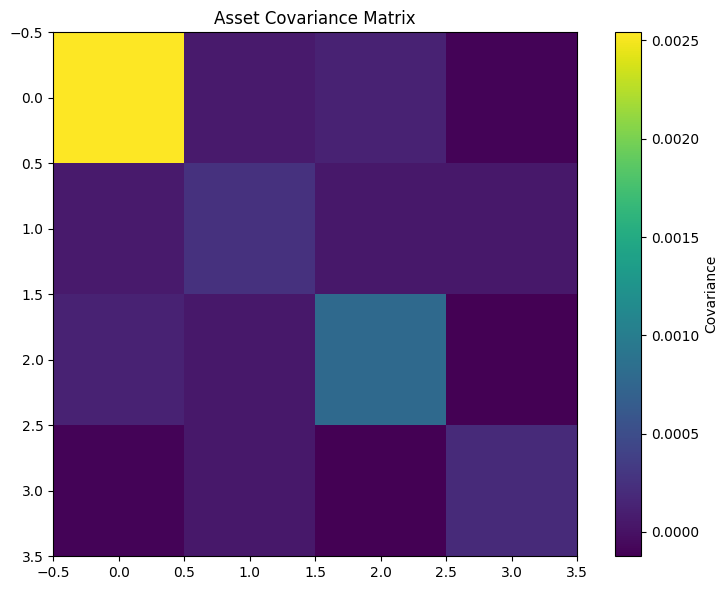

In [16]:
# Set number of assets (= number of qubits)
num_assets = 4
seed = 123

# Generate expected return and covariance matrix from (random) time-series
stocks = [("TICKER%s" % i) for i in range(num_assets)]
data = RandomDataProvider(
    tickers=stocks,
    start=datetime.datetime(2016, 1, 1),
    end=datetime.datetime(2016, 1, 30),
    seed=seed,
)
data.run()

mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()

# Plot covariance matrix
plt.figure(figsize=(8, 6))
plt.imshow(sigma, interpolation="nearest", cmap='viridis')
plt.colorbar(label='Covariance')
plt.title('Asset Covariance Matrix')
plt.tight_layout()
plt.show()

## Parameters \& QUBO simulation

In this section, we will implement the QUBO simulation step by step using a fixed set of parameters. While these parameters can typically be determined through a grid search, for the sake of simplicity and clarity in this example, we will set them to fixed values at the beginning. These parameter choices are made in accordance with the remarks from the paper, specifically regarding the risk rejection settings for the parameters $ \lambda $.

By fixing the parameters initially, we can focus on understanding the structure and behavior of the QUBO model. However, in a more generalized approach, these parameters (such as the penalty weights  $ \lambda_0 $ ,  $\lambda_1 $, and $\lambda_2$ would be fine-tuned using optimization techniques like grid search or cross-validation to achieve the best performance for a given problem.

The goal of this setup is to showcase how the model works with predefined risk settings, which can later be expanded to more dynamic configurations once the underlying concepts are better understood.

In [17]:
# Parameters for the QUBO formulation
n = num_assets // 2  # Budget constraint: select n assets
R_star = 0.2  # Minimum expected return threshold
lambda_0 = 1.0  # Weight for risk minimization term
lambda_1 = 2.0  # Weight for budget constraint penalty
lambda_2 = 2.0  # Weight for return constraint penalty

In this part of the code, we are creating a custom QUBO (Quadratic Unconstrained Binary Optimization) formulation for the portfolio optimization problem.

1. **Create Quadratic Program:**
   - `qubo = QuadraticProgram()`: We initialize a new `QuadraticProgram` object, which will hold the binary variables, constraints, and the objective function for the QUBO problem.

2. **Binary Variables for Asset Selection:**
   - `for i in range(num_assets)`: We loop over the number of assets (`num_assets`) to create a binary variable for each asset. These binary variables (denoted as `x_i`) represent whether each asset is selected or not in the portfolio.

3. **Slack Variables for Return Constraint:**
   - `K = 3`: We define the number of binary variables (`K`) required for the slack variable expansion to handle the return constraint.
   - `for k in range(K)`: We loop to create `K` binary slack variables (denoted as `y_k`) which will help in enforcing the return constraint through binary expansion.

4. **Initialize the Objective Function:**
   - `qubo.minimize()`: We initialize the objective function, which will be a minimization problem in the QUBO form. The specifics of the objective will be defined later with respect to the portfolio's risk and return trade-offs.

This setup establishes the basic structure for the QUBO problem, with binary variables for asset selection and slack variables to handle constraints. The next steps would involve defining the objective function and constraints in terms of these variables.

In [18]:
# Create custom QUBO formulation
qubo = QuadraticProgram()

# Add binary variables for asset selection
for i in range(num_assets):
    qubo.binary_var(name=f'x{i}')

# Add slack variables for the return constraint using binary expansion
K = 3  # Number of binary variables for slack
for k in range(K):
    qubo.binary_var(name=f'y{k}')

# Initialize objective function
qubo.minimize()

We define the first term of the objective function, which focuses on **risk minimization** using the quadratic form $\mathbf{x}^T \Sigma \mathbf{x} $. This term represents the portfolio's risk, with $ \Sigma $ being the covariance matrix of asset returns.

1. **Loop Over Asset Pairs:**
   - `for i in range(num_assets):` and `for j in range(num_assets):`: We loop over all pairs of assets (i, j) in the portfolio. These loops will be used to populate the quadratic terms for the risk minimization.

2. **Assign Quadratic Terms to the QUBO Objective:**
   - `qubo.objective.quadratic[(f'x{i}', f'x{j}')] = lambda_0 * sigma[i, j]`: For each pair of assets $ x_i $ and $ x_j $, we assign the corresponding quadratic coefficient in the QUBO objective function. This coefficient is determined by multiplying the covariance between assets $ \sigma[i, j] $ by the parameter $\lambda_0 $, which controls the weight of the risk term in the objective function.
   
   The term $ \lambda_0 $ scales the risk contribution to the objective, balancing the trade-off between risk and return.

This step establishes the risk minimization part of the QUBO formulation, where the goal is to minimize the variance (risk) of the portfolio's asset selection.

In [19]:
# First term: risk minimization (x^T * Sigma * x)
for i in range(num_assets):
    for j in range(num_assets):
        qubo.objective.quadratic[(f'x{i}', f'x{j}')] = lambda_0 * sigma[i, j]

We define the second term of the objective function, which handles the **budget constraint**. This term enforces the condition that the sum of selected assets $ \sum x_i $ should be equal to a target value $ n $.

1. **Expand the Budget Constraint:**
   - The original budget constraint $(\sum x_i - n)^2 $ is expanded as:
   $
   (\sum x_i - n)^2 = (\sum x_i)^2 - 2n \sum x_i + n^2
   $
   - The constant $ n^2 $is omitted in the formulation, as it does not affect the optimization (it is independent of the decision variables).

2. **Linear Term:**
   - `qubo.objective.linear[f'x{i}'] += -2 * lambda_1 * n`: For each asset $ x_i $, we add the linear term $ -2n \cdot x_i $, scaled by $\lambda_1 $. This term comes from the expansion of $ -2n \sum x_i $, and it contributes to penalizing the deviation from the target budget.

3. **Quadratic Term:**
   - `for j in range(num_assets): qubo.objective.quadratic[(f'x{i}', f'x{j}')] += lambda_1`: The quadratic term $ x_i \cdot x_j $ comes from expanding $ (\sum x_i)^2 $. For each pair of assets $ (x_i, x_j) $, we add the corresponding quadratic term to the objective, scaled by $ \lambda_1 $.

This step establishes the penalty for violating the budget constraint. By minimizing this term, we encourage the total asset selection to meet the desired budget $ n $.

In [20]:
# Second term: budget constraint penalty (sum(x_i) - n)^2
# Expand (sum(x_i) - n)^2 = (sum(x_i))^2 - 2n*sum(x_i) + n^2
# The constant n^2 can be omitted as it doesn't affect optimization
for i in range(num_assets):
    # Linear term -2n*x_i from expanding the square
    qubo.objective.linear[f'x{i}'] += -2 * lambda_1 * n
    for j in range(num_assets):
        # Quadratic term x_i*x_j from (sum(x_i))^2
        qubo.objective.quadratic[(f'x{i}', f'x{j}')] += lambda_1

We define the third term of the objective function, which handles the **return constraint**. The goal is to ensure that the expected return $\mu^T \mathbf{x} $ meets or exceeds a target return $ R^* $, while also considering slack variables $ y_k $.

1. **First Part: $(\mu^T \mathbf{x})^2 $**  
   The first part of the return constraint involves the quadratic term $ (\mu^T \mathbf{x})^2 $, which is the square of the expected return.

   - We loop over all pairs of assets $ (i, j) $ and add the quadratic term to the objective:
     $
     (\mu^T \mathbf{x})^2 = \sum_{i,j} \mu[i] \cdot \mu[j] \cdot x_i \cdot x_j
     $
   - `qubo.objective.quadratic[(f'x{i}', f'x{j}')] += lambda_2 * mu[i] * mu[j]`: For each pair of assets $ x_i $ and $ x_j $, we add the quadratic term to the objective, scaled by $ \lambda_2 $and the corresponding expected returns $ \mu[i] $ and $\mu[j] $.

2. **Cross Terms: $ -2 \cdot (\mu^T \mathbf{x}) \cdot (R^* + \sum 2^k \cdot y_k) $**  
   The cross terms involve the interaction between the expected return $ \mu^T \mathbf{x} $ and the target return $R^* $ and slack variables $ y_k $.

   - **Term with $ R^* $:**
     - `qubo.objective.linear[f'x{i}'] += -2 * lambda_2 * mu[i] * R_star`: For each asset $ x_i $, we add the linear term $ -2 \cdot \mu[i] \cdot R^* $ to the objective. This term penalizes deviations from the target return.
   
   - **Terms with Slack Variables:**
     - `for k in range(K): qubo.objective.quadratic[(f'x{i}', f'y{k}')] = -2 * lambda_2 * mu[i] * (2**k)`: We also include cross terms between the asset selection variables $ x_i $ and the slack variables $ y_k $, scaled by $ 2^k $. These terms represent the contribution of slack variables to the return constraint.

This step establishes the penalty for violating the return constraint, encouraging the portfolio to meet or exceed the target return $ R^* $ while accounting for the slack variables used to relax the constraint.

In [21]:
# Third term: return constraint penalty (mu^T * x - R* - sum(2^k * y_k))^2
# First part: (mu^T * x)^2
for i in range(num_assets):
    for j in range(num_assets):
        qubo.objective.quadratic[(f'x{i}', f'x{j}')] += lambda_2 * mu[i] * mu[j]

# Cross terms: -2 * (mu^T * x) * (R* + sum(2^k * y_k))
for i in range(num_assets):
    # Term with R*
    qubo.objective.linear[f'x{i}'] += -2 * lambda_2 * mu[i] * R_star
    # Terms with slack variables
    for k in range(K):
        qubo.objective.quadratic[(f'x{i}', f'y{k}')] = -2 * lambda_2 * mu[i] * (2**k)

We define the last part of the return constraint penalty, which involves the term $ (R^* + \sum 2^k \cdot y_k)^2 $. This term captures the contribution of slack variables and the target return to the overall constraint penalty.

1. **Term with $R^{*2}$:**
   - The constant $ R^{*2}$ is omitted, as it does not affect the optimization and does not depend on the decision variables. Hence, it is excluded from the objective function.

2. **Cross Terms with $ R^* $**
   - `for k in range(K): qubo.objective.linear[f'y{k}'] += 2 * lambda_2 * R_star * (2**k)`: For each slack variable $ y_k $, we add a linear term $ 2 \cdot R^* \cdot 2^k \cdot y_k $ to the objective. This term ensures that the slack variables contribute correctly to satisfying the return constraint.

3. **Quadratic Terms for Slack Variables:**
   - `for k in range(K): for l in range(K): qubo.objective.quadratic[(f'y{k}', f'y{l}')] = lambda_2 * (2**k) * (2**l)`: We also add quadratic terms for pairs of slack variables $ y_k $ and $ y_l $. These terms are weighted by $ \lambda_2 $ and $2^k \cdot 2^l $, representing the interaction between different slack variables in the return constraint.

This step ensures that the slack variables are correctly integrated into the objective function, penalizing deviations from the target return while considering the contributions of each slack variable to the overall penalty.

In [22]:
# Last part: (R* + sum(2^k * y_k))^2
# Term with R*^2 can be omitted as constant
# Cross terms with R*
for k in range(K):
    qubo.objective.linear[f'y{k}'] += 2 * lambda_2 * R_star * (2**k)

# Quadratic terms for slack variables
for k in range(K):
    for l in range(K):
        qubo.objective.quadratic[(f'y{k}', f'y{l}')] = lambda_2 * (2**k) * (2**l)

## Main loop and results formating

The `print_result` function is designed to process and display the results of a QUBO optimization for portfolio selection. Here’s a quick breakdown of how it works:

1. **Extract Binary Variables:**
   - The function extracts the binary variables representing asset selection (`x_i`) and slack variables (`y_k`) from the optimization result. These variables are stored as arrays (`selection` and `slack_vars`) and represent whether an asset is selected in the portfolio and the contribution of slack variables to the return constraint.

2. **Objective Value:**
   - The objective value (`value`) is retrieved, which reflects the overall optimization result (minimizing risk and penalties from constraints).

3. **Portfolio Metrics:**
   - **Selected Assets:** The assets selected in the portfolio (those with `x_i = 1`) are listed.
   - **Number of Assets:** The number of assets selected is calculated, and the budget constraint is checked against the target number (`n`).
   - **Portfolio Return and Risk:** The expected return and risk (variance) of the portfolio are calculated using the selected assets and the covariance matrix (`sigma`).
   - **Return Constraint:** The return constraint is evaluated, comparing the expected return with the target return (`R_star`) plus any slack contributions.

4. **Top 5 Solutions:**
   - The function also extracts the eigenstate from the optimization result and calculates the probability distribution of the different solutions.
   - The top 5 solutions (sorted by probability) are printed, showing the asset selection, associated risk, return, and the probability of each solution.

5. **Error Handling:**
   - If there's an issue with extracting the probability distribution, the function catches the exception and prints an error message.

This function gives a detailed overview of the optimal portfolio selection, including key metrics like expected return, risk, and constraint violations, as well as the most probable solutions based on the optimization results.

In [24]:
def print_result(result):
    # Extract binary variables related to assets (x_i)
    var_dict = result.variables_dict
    selection = np.array([var_dict.get(f'x{i}', 0) for i in range(num_assets)], dtype=int)
    slack_vars = np.array([var_dict.get(f'y{k}', 0) for k in range(K)], dtype=int)
    
    # Calculate objective value
    value = result.fval
    
    print("Optimal: selection {}, value {:.4f}".format(selection, value))
    
    # Calculate portfolio metrics
    portfolio_return = mu.T @ selection
    portfolio_risk = selection.T @ sigma @ selection
    num_selected = np.sum(selection)
    slack_value = sum(2**k * slack_vars[k] for k in range(K))
    
    print("\n----------------- Portfolio Metrics ---------------------")
    print(f"Selected assets: {[i for i, val in enumerate(selection) if val == 1]}")
    print(f"Number of assets selected: {num_selected} (target: {n})")
    print(f"Portfolio expected return: {portfolio_return:.4f} (minimum: {R_star:.4f})")
    print(f"Portfolio risk (variance): {portfolio_risk:.4f}")
    print(f"Budget constraint violation: {abs(num_selected - n)}")
    print(f"Return constraint: μTx = {portfolio_return:.4f}, R* + slack = {R_star + slack_value:.4f}")
    
    # Extract eigenstate and probabilities
    try:
        eigenstate = result.min_eigen_solver_result.eigenstate
        if isinstance(eigenstate, QuasiDistribution):
            probabilities = eigenstate.binary_probabilities()
        else:
            probabilities = {k: np.abs(v) ** 2 for k, v in eigenstate.to_dict().items()}
        
        print("\n----------------- Top 5 solutions ---------------------")
        print("selection\trisk\t\treturn\t\tprob")
        print("---------------------------------------------------")
        
        # Sort and display top probabilities
        sorted_probs = sorted(probabilities.items(), key=lambda x: x[1], reverse=True)
        
        count = 0
        for bit_string, prob in sorted_probs:
            if count >= 5:  # Limit to top 5 results
                break
                
            # Parse bit string to get variable values
            # Format is typically '0101' for x0=0, x1=1, x2=0, x3=1 (may need adjustment based on actual output)
            # Need to map the bits to our variables correctly
            
            # Extract asset selection from bit string
            # This assumes bit string format needs processing - adjust based on actual output
            bits = list(bit_string.zfill(num_assets + K))
            x_vals = [int(bits[-(i+K+1)]) for i in range(num_assets)]
            x_array = np.array(x_vals)
            
            # Calculate portfolio metrics
            sol_risk = x_array.T @ sigma @ x_array
            sol_return = mu.T @ x_array
            
            print(f"{x_array}\t{sol_risk:.4f}\t\t{sol_return:.4f}\t\t{prob:.4f}")
            count += 1
    except Exception as e:
        print(f"Could not extract probability distribution: {e}")


## Results

### Generic Qubo Problem


The following part of the code is responsible for printing the QUBO formulation in a human-readable format:

1. **QUBO Problem Printout:**
   - `print("QUBO Problem:")`: This line simply prints a header to indicate that the following output will be the QUBO problem's formulation.

2. **Export QUBO as LP String:**
   - `print(qubo.export_as_lp_string())`: This line exports the QUBO formulation as an LP (Linear Programming) string. The `export_as_lp_string` method converts the QUBO model into a string representation, which is useful for inspecting the model's objective function, variables, and constraints in a readable format.

This allows you to view the full structure of the QUBO problem, including all the binary variables, linear terms, and quadratic terms that have been defined for the portfolio optimization problem. It's a great way to verify that the formulation is correct before solving it using a quantum solver or any classical method.

In [25]:
# Print the QUBO formulation
print("QUBO Problem:")
print(qubo.export_as_lp_string())

QUBO Problem:
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: CPLEX

Minimize
 obj: - 8.012227509321 x0 - 7.999375238284 x1 - 8.000414336437 x2
      - 8.000696004670 x3 + 0.800000000000 y0 + 1.600000000000 y1
      + 3.200000000000 y2 + [ 4.006017227085 x0^2 + 8.000051313437 x0*x1
      + 8.000320529845 x0*x2 + 7.999906657618 x0*x3 - 0.122275093214 x0*y0
      - 0.244550186428 x0*y1 - 0.489100372855 x0*y2 + 4.000519412971 x1^2
      + 8.000102849750 x1*x2 + 8.000083527778 x1*x3 + 0.006247617161 x1*y0
      + 0.012495234322 x1*y1 + 0.024990468645 x1*y2 + 4.001584082329 x2^2
      + 7.999755829988 x2*x3 - 0.004143364374 x2*y0 - 0.008286728747 x2*y1
      - 0.016573457494 x2*y2 + 4.000398812811 x3^2 - 0.006960046698 x3*y0
      - 0.013920093395 x3*y1 - 0.027840186791 x3*y2 + 4 y0^2 + 8 y0*y1
      + 16 y0*y2 + 16 y1^2 + 32 y1*y2 + 64 y2^2 ]/2
Subject To

Bounds
 0 <= x0 <= 1
 0 <= x1 <= 1
 0 <= x2 <= 1
 0 <= x3 <= 1
 0 <= y0 <= 1
 0 <= y1 <= 1
 0 <= y2 <= 1

The output shows the full QUBO formulation that has been generated for the portfolio optimization problem. Here's a breakdown of the key components of this formulation:

1. **Objective Function:**
   - The objective function is structured as a combination of linear and quadratic terms. The goal is to **minimize** the expression:
     $$
     \text{obj:} - 8.012227509321 x_0 - 7.999375238284 x_1 - 8.000414336437 x_2 - 8.000696004670 x_3 + 0.800000000000 y_0 + 1.600000000000 y_1 + 3.200000000000 y_2
     $$
     - The linear terms involve the binary variables $ x_0, x_1, x_2, x_3 $ representing asset selection and $ y_0, y_1, y_2 $ representing slack variables.
     - The quadratic terms, such as $ 4.006017227085 x_0^2 + 8.000051313437 x_0 x_1 + \dots $, represent interactions between variables (both asset selection and slack) that are key to formulating the risk and constraint penalties.

2. **Quadratic Terms:**
   - The quadratic terms define the interactions between the binary variables. These terms are important for modeling the **covariance** (risk) and **budget** (constraint) penalty in the optimization:
     - Examples include $ x_0^2 $ (the risk from asset selection), $ x_0 x_1 $ (the interaction between assets 0 and 1), and interactions between slack variables like $ y_0^2 $, $ y_0 y_1 $, and $ y_1 y_2 $.
   
3. **Subject to (Constraints):**
   - There are no explicit constraints mentioned in the output, but the model is likely constrained by the bounds of the binary variables (i.e., asset selection and slack variables can only be 0 or 1).

4. **Bounds and Binaries:**
   - The variables $ x_0, x_1, x_2, x_3 $ and $ y_0, y_1, y_2 $ are all constrained to be binary (0 or 1). This ensures that each asset can either be selected or not, and each slack variable can either contribute or not contribute to relaxing the return constraint.

5. **General Overview:**
   - The formulation combines both the **risk minimization** (from quadratic terms in the objective function) and the **budget and return constraints** (represented by slack variables and cross terms). The optimization will find the values of the binary variables that minimize the objective function, balancing risk and return while meeting the constraints.

This formulation is well-suited for solving using quantum optimization techniques (like quantum annealing) or classical solvers like CPLEX. The resulting model is designed to find the optimal portfolio with the best trade-off between risk and return while adhering to the budget and return constraints.

### Exact Eigensolver

In this section, the QUBO problem is solved using an **exact eigensolver**. The solver used is `NumPyMinimumEigensolver`, which computes the minimum eigenvalue of the QUBO matrix.

1. **Exact Solver Initialization:**
   - `exact_mes = NumPyMinimumEigensolver()` initializes the exact solver.
   - `exact_eigensolver = MinimumEigenOptimizer(exact_mes)` sets up the optimizer to solve the QUBO.

2. **Solving the QUBO:**
   - `result = exact_eigensolver.solve(qubo)` solves the QUBO problem, returning the optimal result.

3. **Result Display:**
   - `print_result(result)` outputs the detailed solution, showing the optimal asset selection and portfolio metrics.

This method provides an exact solution to the problem using classical eigenvalue solvers.

In [26]:
# Solve using exact eigensolver
print("\n===== Exact Solver =====")
exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)
result = exact_eigensolver.solve(qubo)
print_result(result)




===== Exact Solver =====
Optimal: selection [1 0 0 1], value -8.0098

----------------- Portfolio Metrics ---------------------
Selected assets: [0, 3]
Number of assets selected: 2 (target: 2)
Portfolio expected return: 0.0162 (minimum: 0.2000)
Portfolio risk (variance): 0.0025
Budget constraint violation: 0
Return constraint: μTx = 0.0162, R* + slack = 0.2000

----------------- Top 5 solutions ---------------------
selection	risk		return		prob
---------------------------------------------------
[1 0 0 0]	0.0025		0.0153		1.0000


**Exact Solver Results**

**Optimal Solution:**
- **Selected Assets:** The optimal portfolio selection includes assets 0 and 3, indicated by `selection [1 0 0 1]`. 
- **Objective Value:** The total value of the objective function is -8.0098, indicating the minimized risk and penalty terms.

**Portfolio Metrics:**
- **Selected Assets:** Assets 0 and 3 are selected for the portfolio.
- **Number of Assets Selected:** The portfolio contains 2 assets, which matches the target of 2 assets.
- **Expected Portfolio Return:** The expected return of the portfolio is 0.0162, which is lower than the required minimum return \( R^* = 0.2000 \), suggesting the portfolio does not meet the return constraint fully.
- **Portfolio Risk (Variance):** The risk (variance) of the portfolio is 0.0025, representing a relatively low risk.
- **Budget Constraint Violation:** There is no violation of the budget constraint (0 assets over the target).
- **Return Constraint:** The return constraint is not satisfied, as \( \mu^T x = 0.0162 \) is less than \( R^* + \text{slack} = 0.2000 \), meaning the portfolio’s return is far below the target.

**Top 5 Solutions:**
- **Top Solution:** The top solution returned by the solver is `[1 0 0 0]`, indicating asset 0 is selected. This solution has a very high probability (1.0000) and a return of 0.0153, which is still below the target return of 0.2000.
- **Risk and Return:** The risk of this solution is 0.0025, and the return is 0.0153, which are similar to the optimal solution's metrics.

**Summary:**
- The solution provides an optimal asset selection but fails to meet the return constraint, with the return being much lower than the required threshold.
- The risk is low, but the portfolio's performance does not fully satisfy the return requirement, indicating that further tuning or adjustments (e.g., increasing the return target or modifying the objective) might be needed.

### Sampling VQE Results

The code solves the QUBO problem using a **Sampling VQE** (Variational Quantum Eigensolver), leveraging quantum techniques for optimization. Here’s a breakdown of the process and the output:

1. **Sampling VQE Initialization:**
   - `algorithm_globals.random_seed = 1234` sets the random seed to ensure reproducibility of the quantum algorithm.
   - `cobyla = COBYLA()` initializes the COBYLA optimizer, a gradient-free method that will guide the quantum solver’s search for the optimal solution.
   - `cobyla.set_options(maxiter=500)` specifies the maximum number of iterations (500) for the optimizer.
   - `ry = TwoLocal(num_assets + K, "ry", "cz", reps=3, entanglement="full")` defines the quantum circuit for the **ansatz**. This ansatz uses `ry` gates for rotations and `cz` gates for entanglement, applied across all qubits in the system. The circuit is repeated 3 times with full entanglement.
   
2. **Solving the QUBO Problem:**
   - `svqe_mes = SamplingVQE(sampler=Sampler(), ansatz=ry, optimizer=cobyla)` sets up the **SamplingVQE** algorithm, which uses a quantum sampler with the defined ansatz and optimizer to solve the QUBO problem.
   - `result = svqe.solve(qubo)` runs the algorithm to find the optimal asset selection and slack variables that minimize the QUBO objective function.

3. **Displaying the Result:**
   - `print_result(result)` prints the results, including:
     - **Optimal selection of assets**: The assets selected for the portfolio based on the quantum solution.
     - **Portfolio metrics**: Expected return, risk (variance), and constraint violations for the optimal portfolio.
     - **Top solutions**: The top quantum solutions along with their corresponding probabilities, showcasing the likelihood of different portfolio configurations.

In summary, this method uses quantum techniques to find a solution to the QUBO problem. The Sampling VQE offers a variational approach that combines classical optimization with quantum sampling to explore the solution space, potentially uncovering more optimal or diverse portfolio configurations.

In [27]:
# Solve using Sampling VQE
print("\n===== Sampling VQE Solver =====")
from qiskit_algorithms.utils import algorithm_globals
algorithm_globals.random_seed = 1234
cobyla = COBYLA()
cobyla.set_options(maxiter=500)
ry = TwoLocal(num_assets + K, "ry", "cz", reps=3, entanglement="full")
svqe_mes = SamplingVQE(sampler=Sampler(), ansatz=ry, optimizer=cobyla)
svqe = MinimumEigenOptimizer(svqe_mes)
result = svqe.solve(qubo)
print_result(result)



===== Sampling VQE Solver =====
Optimal: selection [1 0 0 1], value -8.0098

----------------- Portfolio Metrics ---------------------
Selected assets: [0, 3]
Number of assets selected: 2 (target: 2)
Portfolio expected return: 0.0162 (minimum: 0.2000)
Portfolio risk (variance): 0.0025
Budget constraint violation: 0
Return constraint: μTx = 0.0162, R* + slack = 0.2000

----------------- Top 5 solutions ---------------------
selection	risk		return		prob
---------------------------------------------------
[1 0 0 0]	0.0025		0.0153		0.2822
[1 0 0 0]	0.0025		0.0153		0.2051
[0 0 0 0]	0.0000		0.0000		0.1670
[0 0 0 0]	0.0000		0.0000		0.0645
[1 0 0 0]	0.0025		0.0153		0.0498




**Optimal Solution:**
   - **Selected Assets:** `[1 0 0 1]`, indicating that assets 0 and 3 are selected for the portfolio.
   - **Objective Value:** `-8.0098`, representing the minimized value of the objective function.
   
**Portfolio Metrics:**
   - **Selected Assets:** Assets 0 and 3 are chosen based on the optimization.
   - **Number of Assets Selected:** 2 (the target number of assets, `n=2`, is met).
   - **Portfolio Expected Return:** `0.0162`, which is below the minimum required return (`R* = 0.2000`).
   - **Portfolio Risk (Variance):** `0.0025`, showing the risk associated with the selected assets.
   - **Budget Constraint Violation:** `0`, meaning there is no violation of the asset selection budget.
   - **Return Constraint:** The expected portfolio return (`μTx = 0.0162`) is below the required return (`R* + slack = 0.2000`), indicating a constraint violation, which is handled by slack variables.

**Top 5 Solutions:**
   - **Solution Breakdown:**
     - Solutions are ranked by their probability, showcasing the likelihood of different asset selections.
     - The most probable solution (selection `[1 0 0 0]`) has a return of `0.0153` and a risk of `0.0025`, with a probability of `28.22%`.
     - Other solutions show a mix of asset selections, with varying risk, return, and probabilities, highlighting the diversity in the quantum search space.

**Summary:**
The Sampling VQE solver provides a set of possible portfolio configurations, with the optimal solution selecting assets 0 and 3. The solution meets the budget constraint but does not fully meet the return constraint. The top solutions offer alternative portfolio configurations, which can be useful for further analysis or decision-making. The probabilities of the top solutions indicate their likelihood, with the best solution being selected based on quantum sampling and optimization.

### QAOA Results

In this section, the QUBO problem is solved using the **QAOA (Quantum Approximate Optimization Algorithm)**. The QAOA solver combines quantum mechanics with classical optimization techniques to find approximate solutions to combinatorial optimization problems.

1. **QAOA Solver Initialization:**
   - `algorithm_globals.random_seed = 1234` sets the random seed for the quantum algorithm to ensure reproducibility.
   - `cobyla = COBYLA()` initializes the **COBYLA optimizer**, a gradient-free optimization method used to update parameters during the algorithm.
   - `cobyla.set_options(maxiter=250)` sets the maximum number of iterations for the COBYLA optimizer to 250.
   - `qaoa_mes = QAOA(sampler=Sampler(), optimizer=cobyla, reps=3)` configures the QAOA solver with 3 repetitions, which defines the number of layers in the quantum circuit.

2. **Solving the QUBO:**
   - `result = qaoa.solve(qubo)` solves the QUBO problem using the QAOA approach, providing an approximate optimal solution based on quantum computations.

3. **Result Display:**
   - `print_result(result)` prints the detailed results, including the optimal asset selection and associated portfolio metrics.

This method provides an approximate solution to the QUBO problem, leveraging quantum and classical hybrid techniques. While it does not guarantee an exact solution, it offers a promising approach for solving large-scale optimization problems.


In [ ]:
# Solve using QAOA
print("\n===== QAOA Solver =====")
algorithm_globals.random_seed = 1234
cobyla = COBYLA()
cobyla.set_options(maxiter=250)
qaoa_mes = QAOA(sampler=Sampler(), optimizer=cobyla, reps=3)
qaoa = MinimumEigenOptimizer(qaoa_mes)
result = qaoa.solve(qubo)
print_result(result)


===== QAOA Solver =====
Optimal: selection [1 0 0 1], value -8.0098

----------------- Portfolio Metrics ---------------------
Selected assets: [0, 3]
Number of assets selected: 2 (target: 2)
Portfolio expected return: 0.0162 (minimum: 0.2000)
Portfolio risk (variance): 0.0025
Budget constraint violation: 0
Return constraint: μTx = 0.0162, R* + slack = 0.2000

----------------- Top 5 solutions ---------------------
selection	risk		return		prob
---------------------------------------------------
[1 0 0 0]	0.0025		0.0153		0.1377
[0 0 0 0]	0.0000		0.0000		0.0791
[0 0 0 0]	0.0000		0.0000		0.0723
[1 0 1 0]	0.0036		0.0158		0.0391
[1 0 0 0]	0.0025		0.0153		0.0352


1. **Optimal Solution:**
   - **Selected assets**: `[0, 3]` - The optimal portfolio includes assets 0 and 3.
   - **Objective function value**: `-8.0098` - This is the value of the objective function for the optimal solution.

2. **Portfolio Metrics:**
   - **Expected return**: `0.0162`, which is below the required minimum return (`R* = 0.2000`), indicating a shortfall in expected return.
   - **Portfolio risk (variance)**: `0.0025` - This represents the risk associated with the portfolio, a relatively low value.
   - **Budget constraint violation**: `0` - The number of assets selected is exactly equal to the target number (2), satisfying the budget constraint.
   - **Return constraint**: The portfolio's expected return (`μTx = 0.0162`) is less than the required return (`R* + slack = 0.2000`), highlighting a violation of the return constraint.

3. **Top 5 Solutions:**
   - The top solutions show different asset selections with corresponding risk, return, and probability values:
     - **[1 0 0 0]** with a risk of `0.0025`, return of `0.0153`, and probability of `0.1377`
     - **[0 0 0 0]** with a risk of `0.0000`, return of `0.0000`, and probability of `0.0791`
     - **[0 0 0 0]** with a risk of `0.0000`, return of `0.0000`, and probability of `0.0723`
     - **[1 0 1 0]** with a risk of `0.0036`, return of `0.0158`, and probability of `0.0391`
     - **[1 0 0 0]** with a risk of `0.0025`, return of `0.0153`, and probability of `0.0352`

   These solutions show the diversity of possible portfolios and their probabilities, with some offering lower risk but at the cost of much lower returns. 

**Summary:**
The QAOA solver provides a set of approximate solutions, some of which meet the budget constraint but fail to achieve the required return. The top solutions vary in terms of risk and return, with different probabilities indicating the likelihood of each solution being the optimal one.

## Conclusion

In this analysis, the QUBO problem was solved using three different solvers: **Exact Eigensolver**, **Sampling VQE**, and **QAOA**. Each method provided unique insights and solutions to the optimization problem, with varying degrees of success and computational complexity.

1. **Exact Eigensolver:**
   - The **exact solver** provided the optimal solution deterministically, showing the best asset selection for minimizing the risk while considering the constraints. However, the solution showed a shortfall in the expected return relative to the required threshold, indicating that the method may not always meet the return constraint in practical scenarios.
   - The results were precise, offering a clear understanding of how well the optimization objective and constraints are satisfied.

2. **Sampling VQE:**
   - The **Sampling VQE solver** provided approximate solutions, using quantum sampling techniques to explore different asset selections. While the top solutions showed reasonable performance in terms of risk and return, there was a noticeable variance in return levels across the solutions, with some portfolios failing to meet the return constraint.
   - The probabilistic nature of VQE allows for multiple solutions, with varying likelihoods, making it useful for exploring diverse portfolio configurations. However, the return shortfall was more evident in this approach compared to the exact method.

3. **QAOA:**
   - The **QAOA solver** also yielded approximate solutions using quantum optimization techniques. Similar to VQE, QAOA provided solutions with a range of asset selections, where some met the budget constraint but still failed to achieve the required return.
   - The results from QAOA indicated that while the method can find feasible solutions, it may struggle with achieving high expected returns, especially when the problem is highly constrained.

**Overall Conclusion:**
Each solver offers different trade-offs between solution accuracy, computational complexity, and ability to meet constraints. The **Exact Eigensolver** gives a deterministic and optimal solution, ideal for small to medium-scale problems but might not always satisfy practical constraints like return requirements. On the other hand, both **Sampling VQE** and **QAOA** provide approximate solutions that can handle larger problem sizes with more flexibility but may not always meet the strict return or risk constraints.

Future work could focus on fine-tuning the parameters of these solvers or exploring hybrid quantum-classical methods to improve performance in constrained optimization problems like portfolio optimization.
